In [2]:
import os
os.chdir('/cluster/medbow/project/phangs/tjuchau/') #TJ change working directory to be the parent directory
from Py_files.Functions import *
image_files, filter_files = collect_M51_image_and_filter_files(filter_directory, image_directory)
import re
from astropy.table import Table
import numpy as np

M51_pa_alpha_file = [x for x in image_files if extract_filter_name(x) == 'F187N'][0]
M51_cont_files = [x for x in image_files if extract_filter_name(x) in ['F150W', "F300M"]]

def get_EW_using_filters(feature_filter_file, continuum_filter_files, location, radius):
    #TJ load files

    #TJ get all 3 image fluxes
    Fnu_feature = get_image_flux(feature_filter_file, location, radius, replace_negatives=False)
    Fnu_cont = [get_image_flux(f, location, radius, replace_negatives=False) for f in continuum_filter_files]
    feature_filter = extract_filter_name(feature_filter_file)
    continuum_filters = [extract_filter_name(x) for x in continuum_filter_files]
    if Fnu_feature.unit != Fnu_cont[0].unit:
        print('units are not the same in the feature image and continuum image!')
    elif Fnu_feature.unit == u.W/(u.m**2*u.Hz):
            
        #TJ look up pivot wavelengths
        pivot_feat = jwst_pivots[feature_filter]
        pivot_cont = [jwst_pivots[extract_filter_name(f)] for f in continuum_filter_files]
        
        #TJ convert continuum levels into F_lambda using pivot wavelengths, still need to multiply by dlamda
        fλ_cont = [(Fnu * c / pivot**2).to(u.W / u.m**2 / u.m)
                   for Fnu, pivot in zip(Fnu_cont, pivot_cont)]
        
        #TJ get mean wavelengths
        cont_wls = [jwst_means[f] for f in continuum_filters]
        line_wl = jwst_means[feature_filter]
    
        #TJ interpolate continuum values to the feature wavelength
        feature_continuum = np.interp(
            line_wl.value,
            [w.value for w in cont_wls],
            [f.value for f in fλ_cont]
        ) * u.W / u.m**2 / u.m
        
        #TJ print continuum if needed
        #print("F_lamda of photo continuum : ", feature_continuum)
        #TJ get filter transmission curve info
        wl, T = get_filter_data(feature_filter)
    
        #TJ multiply feature F_lambda by dlambda to complete unit conversion
        norm = np.trapz(T, wl) / np.max(T)
        cont_in_filter = feature_continuum * norm
        
        #TJ convert feature filter's F_nu into F_lamda
        fλ_feature = ((Fnu_feature * c / pivot_feat**2).to(u.W / u.m**2 / u.m))*norm 
    
        #TJ feature area is only the area above the continuum
        feature_only = fλ_feature - cont_in_filter
    
        #TJEquivalent width is this area divided by the continuum level
        EW = (feature_only / feature_continuum).to(u.m)
    
        return EW
        
    elif Fnu_feature.unit == u.W/u.m**2:
        print('test')

def get_Pa_a_continuum(continuum_filter_files, location, radius):

    #TJ get the two image fluxes
    app_sum = [get_image_flux(f, location, radius, replace_negatives=False) for f in continuum_filter_files]
    continuum_filters = [extract_filter_name(x) for x in continuum_filter_files]
    if app_sum[0].unit != app_sum[1].unit:
        print('units are not the same in the two images!')
        
    elif app_sum[0].unit == u.W/(u.m**2*u.Hz):
        #TJ look up pivot wavelengths
        pivot_feat = jwst_pivots['F187N']
        pivot_cont = [jwst_pivots[extract_filter_name(f)] for f in continuum_filter_files]
        
        #TJ convert continuum levels into F_lambda using pivot wavelengths, still need to multiply by dlamda
        fλ_cont = [(Fnu * c / pivot**2).to(u.W / u.m**2 / u.m)
                   for Fnu, pivot in zip(app_sum, pivot_cont)]

    elif app_sum[0].unit == u.W/u.m**2:
        fλ_cont = []
    
        for Fband, filt in zip(app_sum, continuum_filters):

            wl, T = get_filter_data(filt)

            width = np.trapz(T, wl)  # effective width

            fλ = (Fband / width).to(u.W/u.m**2/u.m)

            fλ_cont.append(fλ)
    #TJ interpolate continuum values to the feature wavelength
    feature_continuum = np.interp(
        pivot_feat.value,
        [w.value for w in pivot_cont],
        [f.value for f in fλ_cont]
    ) * u.W / u.m**2 / u.m
    
    #TJ print continuum if needed
    #print("F_lamda of photo continuum : ", feature_continuum)
    #TJ get filter transmission curve info
    wl, T = get_filter_data("F187N")

    #TJ multiply feature F_lambda by dlambda to complete unit conversion
    norm = np.trapz(T, wl) / np.max(T)
    cont_in_filter = feature_continuum * norm
    return cont_in_filter

def get_filter_Weff(filter_name):
    wl, T = get_filter_data(filter_name)
    return np.trapz(T,wl) / np.max(T)
        
        
def get_galaxy_ID_from_file(file):
    try:
        gal = file.split('/')[-1].split('_')[0]
        return gal
    except:
        return None



In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import glob

# -------------------------------------------------
# Gather file info per galaxy
# -------------------------------------------------
kiana_files = glob.glob('Data_files/Kiana_Cluster_Files/*nircam_all_clusters_results.csv')
radius = 0.3*u.arcsec
data = {}

for file in kiana_files:
    name = get_galaxy_ID_from_file(file)
    data.setdefault(name, {})
    data[name]['files'] = {}

# Danny files (images etc.)
danny_files = glob.glob('/d/crow2/phangs/cycle*/**/*', recursive=True)

for file in danny_files:
    name = get_galaxy_ID_from_file(file)

    if name not in data:
        continue

    if ("f187n_continuum.fits" in file) or ('paa_native_anchor_cont.fits' in file):
        data[name]['files']['F187N_continuum'] = file

    elif ('f187n_line.fits' in file) or ('paa_native_anchor_line.fits' in file):
        data[name]['files']['F187N_line'] = file

    elif extract_filter_name(file) == "F300M":
        data[name]['files']["F300M"] = file

    elif extract_filter_name(file) == "F150W":
        data[name]['files']["F150W"] = file
    elif "f187n_i2d_anchor" in file:
        data[name]['files']["F187N"] = file


galaxy_tables = {}

for file in kiana_files:

    name = get_galaxy_ID_from_file(file)

    # Require needed Pa-alpha files
    if 'F187N' not in data[name]['files']:
        continue

    t = Table.read(file, format="csv")

    locations = []
    ages = []
    stellar_masses = []
    gas_masses = []
    Avs = []
    EWs = []
    mass = []
    for row in t:
        
        loc = SkyCoord(ra=row['ra']*u.deg,
                       dec=row['dec']*u.deg)

        EW = get_EW_using_filters(data[name]['files']['F187N'], [data[name]['files']['F150W'], data[name]['files']['F300M']], loc, radius)
        
        # --- Append ---
        locations.append(loc)
        ages.append(row['best.sfh.age'])
        stellar_masses.append(row['best.stellar.m_star'])
        gas_masses.append(row['best.stellar.m_gas'])
        Avs.append(row['best.attenuation.A550'])
        EWs.append(EW.to(u.AA))
        mass.append(row['best.stellar.m_star'] + row['best.stellar.m_gas'])
    # --- Create Table ---
    tab = Table()
    tab['location'] = locations
    tab['age_Myr'] = ages
    tab['stellar_mass_Msun'] = stellar_masses
    tab['gas_mass_Msun'] = gas_masses
    tab['Av'] = Avs
    tab['PaA_EW'] = EWs
    tab['mass'] = mass
    galaxy_tables[name] = tab


# -------------------------------------------------
# Optional: list galaxies with full data
# -------------------------------------------------
full_data = list(galaxy_tables.keys())


In [7]:
mass_cuts = [1000, 5000, 15000, 50000, 150000, 500000, 1500000, 5000000]
young = galaxy_tables['ngc1433'][galaxy_tables['ngc1433']['age_Myr'] < 20]
galaxy_tables['ngc1433'].sort('mass')
m1 = galaxy_tables['ngc1433'][galaxy_tables['ngc1433']['mass'] < mass_cuts[0]]
m5 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[1]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[0])]
m10 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[2]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[1])]
m50 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[3]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[2])]
m100 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[4]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[3])]
m500 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[5]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[4])]
m1000 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[6]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[5])]
m5000 = galaxy_tables['ngc1433'][(galaxy_tables['ngc1433']['mass'] < mass_cuts[7]) & (galaxy_tables['ngc1433']['mass'] > mass_cuts[6])]
mass_sets = [m1, m5, m10, m50, m100, m500, m1000, m5000]
for set in mass_sets:
    print(len(set))
    print(np.mean(set['mass']))

KeyError: 'ngc1433'

In [9]:
data

{}

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/project/phangs/tjuchau/slug2')  # Path to slug2 directory


import os
home_directory = "/project/phangs/tjuchau/" 
os.chdir(home_directory) #TJ change working directory to be the parent directory
from Py_files.Basic_analysis import *

import glob
import re
slug_path = "/project/phangs/tjuchau/slug2/bin/slug"
os.chdir("/project/phangs/tjuchau/slug2")
import slugpy
wd = '/project/phangs/tjuchau'


def try_float(x):
    '''
    Try to convert an item or an array of items to float.
    If conversion fails, returns original value(s).
    
    Parameters
    ----------
    x : scalar or array-like
        Item(s) to convert.
    
    Returns
    -------
    float, array of floats, or original input if conversion fails.
    '''
    # If x is array-like, attempt vectorized conversion
    if isinstance(x, (list, np.ndarray)):
        try:
            return np.array(x, dtype=float)
        except ValueError:
            return x
    else:
        # Scalar input
        try:
            return float(x)
        except ValueError:
            return x
            
def do_alex_model(model_name, mass, N=1000):
    '''Replication of Alex's model'''
    input_file = f"{model_name}.slugin"
    
    with open(input_file, 'w') as f:
        f.write(f'model_name {model_name}\n')
        f.write(f'out_dir /project/phangs/tjuchau/Data_files/Misc_data/Slug_outputs\n') #TJ this is where the output files will be written to
        f.write(f'verbosity 1\n') #TJ level of printed outputs while running (0=only warnings/errors) (1=some outputs) (2=lots of outputs)
        ##################################################################
        # Parameters controlling simulation execution and physical model #
        ##################################################################
        f.write(f'sim_type cluster\n') #TJ must be either galaxy or cluster (defaults to galaxy)
        f.write(f'n_trials {N}\n') #TJ total number of model clusters to run
        #f.write(f'checkpoint_interval = 100\n') #TJ create checkpoint after this many trials (default to no checkpointing)
        f.write(f'time_step 1.0e6\n') #TJ simulation runs for 1million years before computing new values
        #f.write(f'start_time 1.0e6\n') #TJ default start time is the same as timestep
        f.write(f'end_time 1.0e7\n') #TJ how long does each simulation run for in years
        #f.write(f'sfr 0.001\n') #TJ star formation rate, ignored for sim types = cluster
        #f.write(f'sfh sfh.txt\n') #TJ star formation history, ignored for sim types = cluster
        f.write(f'cluster_mass {mass}\n') #TJ cluster mass in solar masses, ignored for sim type = galaxy
        #f.write(f'redshift 0\n') #TJ defaults to 0
        ##################################################################
        # Parameters controlling simulation outputs #
        ##################################################################
        f.write(f'out_cluster 1\n') #TJ output cluster properties? default = 1
        f.write(f'out_cluster_phot 1\n') #TJ output cluster photometry? (must specify filters also)
        f.write(f'out_cluster_spec 0\n') #TJ output cluster spectroscopy? *adds significant computation time*
        f.write(f'out_cluster_yield 1\n') #TJ output cluster nucleosynthesis yields?
        #f.write(f'out_integrated 1\n') #TJ output integrated properties of galaxy? ignored for sim types = cluster
        #f.write(f'out_integrated_phot 1\n') #TJ output integrated photometry of galaxy? ignored for sim types = cluster
        #f.write(f'out_integrated_spec 1\n') #TJ output integrated spectroscopy of galaxy? ignored for sim types = cluster
        #f.write(f'out_integrated_yield 1\n') #TJ output integrated chemical yields of galaxy? ignored for sim types = cluster
        f.write(f'output_mode ascii\n') #TJ can be either binary, ascii, or fits
        #####################################################################
        # Parameters controlling the physical models used for stars         #
        #####################################################################
        #f.write(f'imf lib/imf/chabrier.imf\n') #TJ what imf to use? defaults to chabrier 2001
        #f.write(f'cmf lib/cmf/slug_default.cmf\n') #TJ cluster mass function for galaxies, ignored for sim types = cluster
        f.write(f'clf lib/clf/nodisrupt.clf\n') #TJ cluster lifetime Default: lib/clf/slug_default.clf (dN/dt ~ t^-1.9)
        f.write(f'tracks mist_2016_vvcrit_40\n') #TJ choose the stellar track. Defaults to geneva_2013_vvcrit_00
        f.write(f'atmospheres lib/atmospheres\n') #TJ directory of the stellar atmospheres
        f.write(f'specsyn_mode sb99\n') #TJ Spectral synthesis mode, describing which models to use for stellar atmospheres allowed values below
        # -- planck (treat stars as blackbodies)
        # -- kurucz (use Kurucz atmospheres, as compiled by Lejeune+ 1997)
        # -- kurucz+hillier (use Hillier models for WR stars, kurucz for all others)
        # -- kurucz+pauldrach (use Pauldrach models for OB stars, kurucz for others)
        # -- sb99 (emulate starburst99 -- Pauldrach for OB stars, Hillier for WR stars, kurucz for others) This is the default value
        f.write(f'clust_frac 1.0\n') #TJ fraction of stars born in clusters (always 1.0 for sim types = cluster)
        f.write(f'min_stoch_mass 0.08\n') #TJ minimum stochastically sampled mass. Everything below is considered to be continuously sampled
        #f.write(f'metallicity       1.0\n') #TJ metalicity function. If tracks is specified, this should be omitted
        #####################################################################
        # Parameters controlling extinction                                 #
        #####################################################################
        f.write(f'A_V lib/avdist/slug_default.av\n') #TJ set extinction function
        f.write(f'extinction_curve lib/extinct/MW_EXT_SLUG.dat\n') #TJ shape of extinction curve
        f.write(f'nebular_extinction_factor lib/avdist/neb_factor_default.av\n') #TJ use a different extinction law for nebulae
        #####################################################################
        # Parameters controlling nebular emission                           #
        #####################################################################
        f.write(f'compute_nebular 1\n') #TJ compute nebular emission specifically?
        #f.write(f'atomic_data lib/atomic\n') #TJ atomic information, defaults to lib/atomic
        #f.write(f'nebular_no_metals 0\n') #TJ 1 would be to turn off nebular metal emission (includes He), 0 means leave metals on
        #f.write(f'nebular_den 1.0e2\n') #TJ hydrogen density (default is 100)
        #f.write(f'nebular_temp -1.0\n') #TJ nebular temperature, default is -1, if negative, temp will be calculated from cloudy
        f.write(f'nebular_logU -2.5\n') #TJ logU representing ionization parameter
        f.write(f'nebular_phi 0.73\n') #TJ fraction of ionizing photons that are absorbed by Hydrogen atoms
        #############################################
        # Parameters describing photometric filters #
        #############################################
        f.write(f'phot_bands JWST_F150W, JWST_F187N, JWST_F300M\n') #TJ list of filters for photometric results
        f.write(f'filters lib/filters\n') #TJ directory for filter information to be read from
        #f.write(f'phot_mode Lnu\n') #TJ what units should the photometry results print in?
        ############################################
        # Parameters controlling yield calculation #
        ############################################
        f.write(f'yield_dir lib/yields\n') #TJ directory for yield files
        
        # are available:
        # 
        
        # 
        f.write(f'yield_mode sukhbold16+karakas16+doherty14\n') #TJ Model to use for yield calculation. Currently the following models accepted:
        # -- sukhbold16 = Solar metallicity type II SN yields from Sukhbold et al. (2016, ApJ, 821, 38); no other yields
        # -- # karakas16+doherty14 = metallicity-dependent AGB star yields from Karakas & Lugaro (2016, ApJ, 825, 26), and super- 
        #                                                                                 AGB star yields from Doherty+ (2014, MNRAS, 437, 195)
        # -- sukhbold16+karakas16+doherty14 = sukhbold16 used for SNII, karakas16+doherty14 for AGB
        f.write(f'\n')

    return input_file


def read_all_files(model_name):
    '''
    Reads all SLUG output .txt files for a given model_name into a dictionary of numpy arrays.
    Keys are column names, values are data arrays.
    '''
    output = {}
    files = glob.glob(f'/project/phangs/tjuchau/Data_files/Misc_data/Slug_outputs/*_cluster*.txt')
    
    for file in files:
        with open(file, 'r') as f:
            lines = f.readlines()
        
        # Get column names
        col_names = lines[0].strip().split()
        n_cols_names = len(col_names)
        
        # Parse data lines
        data_entries = []
        for line in lines[2:]:
            stripped = line.strip()
            if line.startswith('---------'):
                continue
            entries = stripped.split()
            
            # Pad missing entries with 'nan'
            if len(entries) < n_cols_names:
                entries += ['nan'] * (n_cols_names - len(entries))
            data_entries.append(entries)
        
        # Skip empty files gracefully
        if not data_entries:
            continue
        
        # Convert to numpy array of strings first
        data_array = np.array(data_entries, dtype='U20')
        
        # Convert each column individually to float if possible, else keep as string
        for i, name in enumerate(col_names):
            col = data_array[:, i]
            try:
                col_converted = col.astype(float)
            except ValueError:
                col_converted = col  # keep as string if conversion fails
            
            if name in output:
                print(f"Warning: Duplicate column name '{name}' found. Overwriting previous value.")
            output[name] = col_converted
    
    return output


def compute_paalpha_ew(data):  
    """  
    Compute Paα flux and equivalent width from SLUG output.  

    Args:  
        data (dict): Dictionary with filter fluxes (e.g., 'JWST_F150W').  

    Returns:  
        dict: Paα flux (Jy), continuum (Jy), and EW (Å).  
    """  
    # Extract fluxes (adjust keys if needed)  
    f150 = data['JWST_F150W']  # Continuum filter 1  
    f300 = data['JWST_F300M']  # Continuum filter 2  
    f187n = data['JWST_F187N'] # Paα filter  
    f187c = data['JWST_F187N_n'] #continuum around Paa
    # Estimate continuum at Paα (1.875 µm) by linear interpolation  
    # Wavelengths (µm) for each filter (central λ from JWST)  
    lambda150 = jwst_pivots['F150W'].to(u.um).value
    lambda187 = jwst_pivots['F187N'].to(u.um).value
    lambda300 = jwst_pivots['F300M'].to(u.um).value

    # Linear fit to continuum (F150W and F200W)  
    slope = (f300 - f150) / (lambda300 - lambda150)  
    continuum = f150 + slope * (lambda187 - lambda150)  
    
    # Subtract continuum to isolate Paα flux  
    paalpha_flux = f187n - continuum  
    paalpha_flux_c = f187n - f187c
    # Compute equivalent width (EW) in Ångströms  
    # EW = Δλ (F_line / F_continuum), where Δλ = F187N filter width (~0.02 µm = 200 Å)  
    f187n_width = 0.02 * 1e4  # Convert µm to Å (1 µm = 1e4 Å)  
    ew = f187n_width * (paalpha_flux / continuum)  
    ew_c = f187n_width * (paalpha_flux_c / f187c)  

    return {'paalpha_flux': paalpha_flux, 'continuum': continuum, 'EW': ew,
            'paalpha_flux_c': paalpha_flux, 'continuum_c': continuum, 'EW_c': ew_c}

N_array = [1000, 1000, 1000, 1000, 800, 700, 500, 250]
mass_sets = [{'mass':1e2}, {'mass':1e3}, {'mass':1e4}, {'mass':1e5}, {'mass':1e6}, {'mass':1e7}, {'mass':1e8}, {'mass':1e9},]
for i, set in enumerate(mass_sets):
    m = int(np.round(np.mean(set['mass'])))
    model_name = f'testing_young_cluster_mass_{m}'
    slug_input_file = do_alex_model(model_name, m, N=N_array[i])
    os.system(f'{slug_path} {slug_input_file}')
    temp = read_all_files(model_name)
    rows = [dict(zip(temp.keys(), values)) for values in zip(*temp.values())]
    ews = []
    ews_c = []
    for row in rows:
        ews.append(compute_paalpha_ew(row)['EW'])
        ews_c.append(compute_paalpha_ew(row)['EW_c'])
    data = np.array([temp['Time'], ews, ews_c])
    np.save(f'/d/ret1/Taylor/jupyter_notebooks/Research/SLUG_stuff/datasets/young_{m}_mass_EW.npy', data)


/project/phangs/tjuchau/slug2/bin/slug: error while loading shared libraries: libcfitsio.so.10: cannot open shared object file: No such file or directory


KeyError: 'Time'

/apps/u/opt/linux/miniconda3/24.3.0/condabin/conda


0

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1000,) + inhomogeneous part.

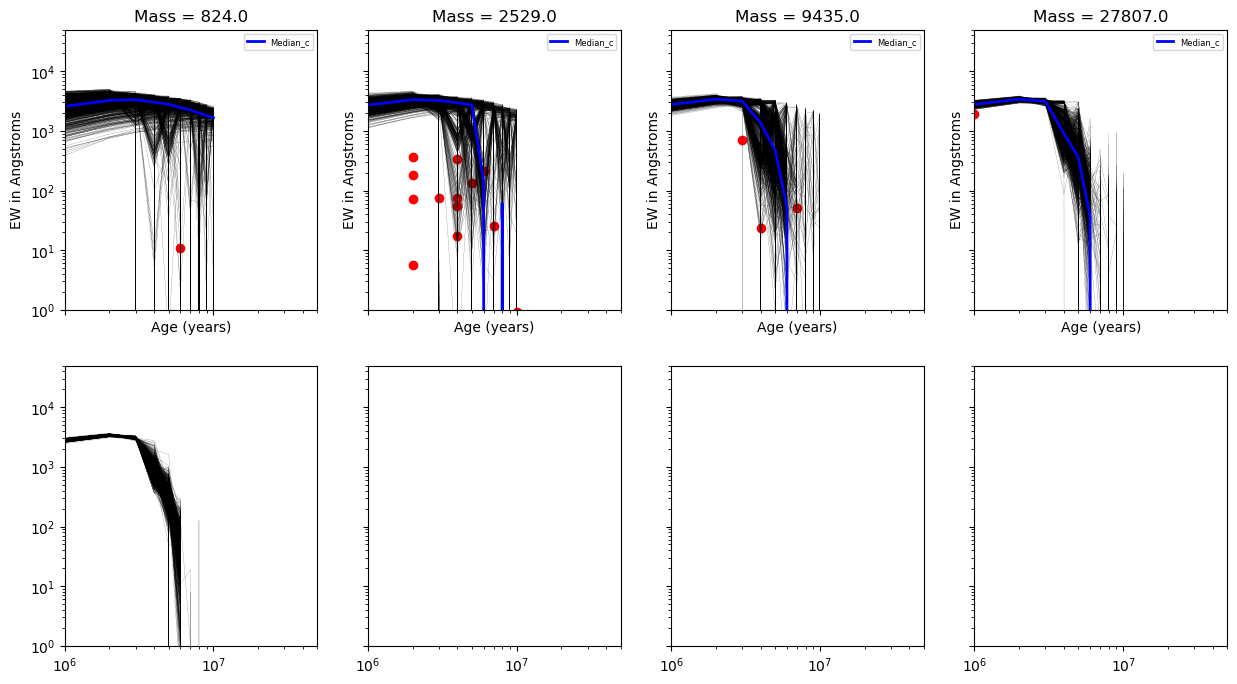

In [6]:

# Determine grid size (e.g. 2 rows x 3 columns for 6 plots)
n_cols = 4
n_rows = int(np.ceil(len(mass_sets) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, set in enumerate(mass_sets[:-1]):
    m = np.round(np.mean(set['mass']))
    data = np.load(f'/d/ret1/Taylor/jupyter_notebooks/Research/SLUG_stuff/datasets/young_{m}_mass_EW.npy')
    
    ax = axes[i]
    chunk_data = []
    c_chunk_data = []
    for chunk in range(1000):
        start = 10*chunk
        ax.plot(data[0][start:start+10], data[1][start:start+10], linewidth = 0.1, color = 'black')
        chunk_data.append(data[1][start:start+10])
        c_chunk_data.append(data[2][start:start+10])
        
    chunk_data = np.array(chunk_data)  # shape: (100, 10)
    c_chunk_data = np.array(chunk_data)  # shape: (100, 10)
    
    # Calculate median across chunks for each timestep
    median_y = np.nanmedian(chunk_data, axis=0)
    median_y_c = np.nanmedian(c_chunk_data, axis=0)
    
    # Overplot median track
    ax.plot(data[0][start:start+10], median_y_c, color='blue', linewidth=2, label='Median_c')
    ax.scatter(set['age_Myr']*1e6, set['PaA_EW'], color = 'red')
    ax.set_title(f'Mass = {m}')
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('EW in Angstroms')
    ax.legend(fontsize=6)
    ax.set_xscale('log')
    ax.set_xlim([1e6,5e7])
    ax.set_ylim([1e0,5e4])
    ax.set_yscale('log')
# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

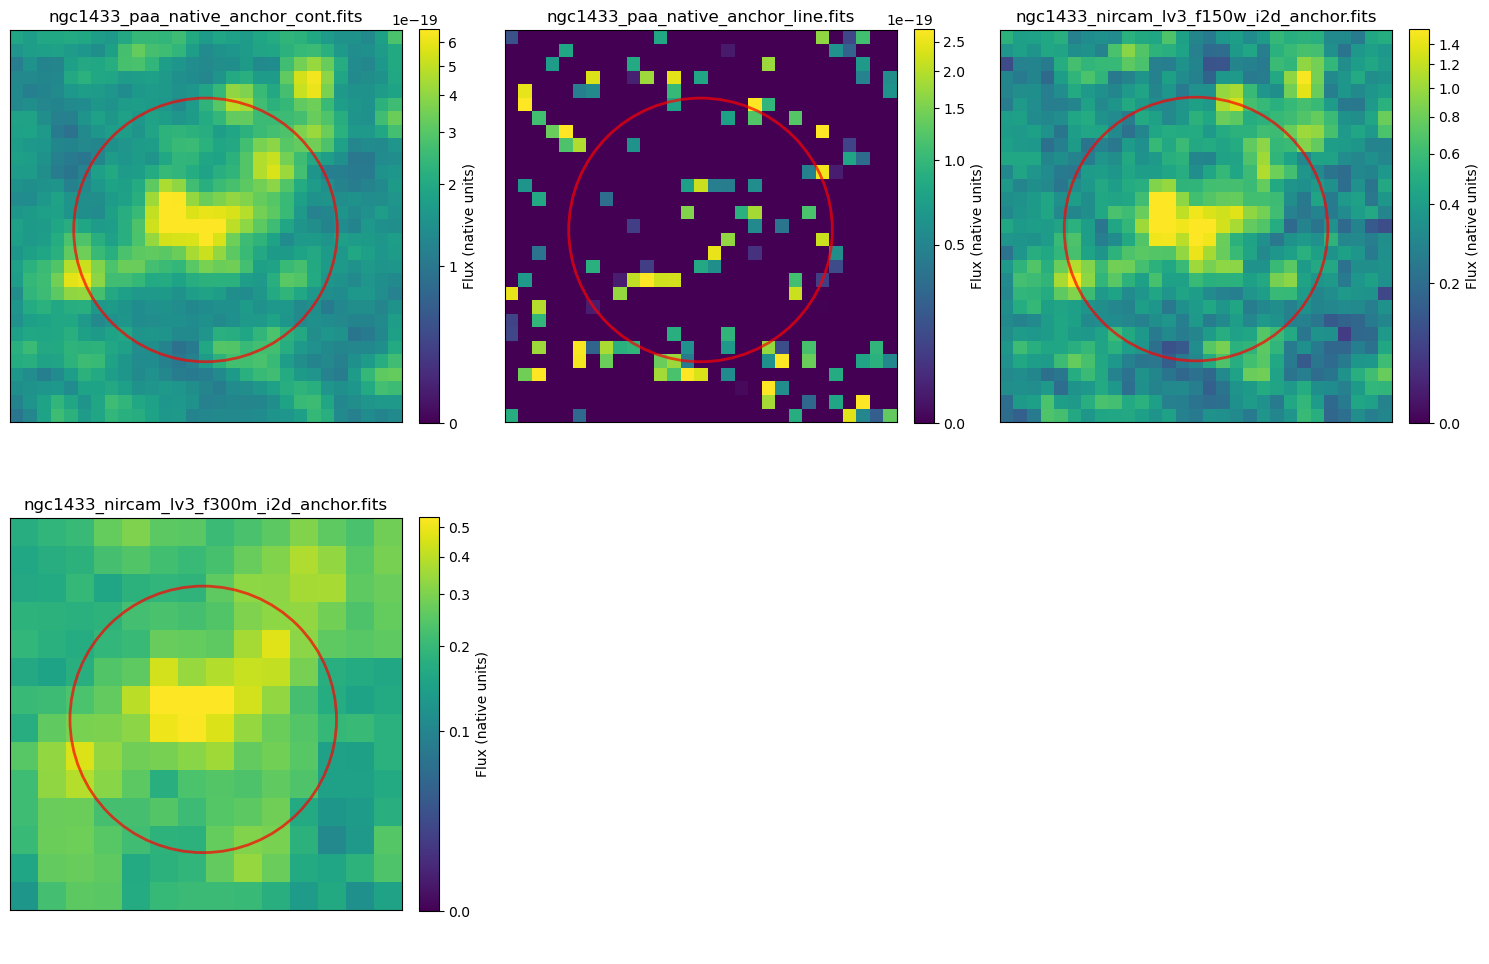

7.699738677828699e-20 W / m2
-6.979074518411729e-20 W / m2
3.8282553138645e-32 W / (Hz m2)
1.995748705902228e-32 W / (Hz m2)


<Quantity 4.65998259e-31 W / (Hz m2)>

In [3]:
test = data['ngc1433']
loc = test['region_1']['location']
radius = 0.3*u.arcsec
files = [test['files'][x] for x in test['files']]
show_images(files, loc, radius)
for file in files:
    print(get_image_flux(file, loc, radius))
get_image_flux(image_files[0], locations[0], radius)

In [10]:
for i in range(173):
    print('Region ',i)
    loc = test[f'region_{i}']['location']
    print('continuum flux : ', get_image_flux(test['files']['F187N_continuum'], loc, radius))
    print('Predicted continuum : ', get_Pa_a_continuum([test['files']['F150W'], test['files']['F300M']], loc, radius))
    print('line flux : ', get_image_flux(test['files']['F187N_line'], loc, radius))

Region  0
continuum flux :  7.699738677828699e-20 W / m2
Predicted continuum :  9.430858147555919e-20 W / m2
line flux :  -6.979074518411729e-20 W / m2
Region  1
continuum flux :  1.0192800120749968e-19 W / m2
Predicted continuum :  1.3185046424311844e-19 W / m2
line flux :  -5.59835343677443e-20 W / m2
Region  2
continuum flux :  1.3006758859419494e-19 W / m2
Predicted continuum :  1.6894429430741907e-19 W / m2
line flux :  -3.144357593602301e-20 W / m2
Region  3
continuum flux :  9.284258743117572e-20 W / m2
Predicted continuum :  1.297592422809986e-19 W / m2
line flux :  9.368753821786432e-21 W / m2
Region  4
continuum flux :  7.40295805266614e-20 W / m2
Predicted continuum :  1.0650976213647324e-19 W / m2
line flux :  4.2623578275756424e-20 W / m2
Region  5
continuum flux :  9.908283642937594e-20 W / m2
Predicted continuum :  1.3877754062841016e-19 W / m2
line flux :  -6.853348960871809e-21 W / m2
Region  6
continuum flux :  1.2076067095847397e-19 W / m2
Predicted continuum :  1.65

In [22]:
test['files']

{'F187N_continuum': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_cont.fits',
 'F187N_line': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_line.fits',
 'F150W': '/d/crow2/phangs/cycle3/ngc1433_nircam_lv3_f150w_i2d_anchor.fits',
 'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1433_nircam_lv3_f300m_i2d_anchor.fits'}

In [ ]:
full_data

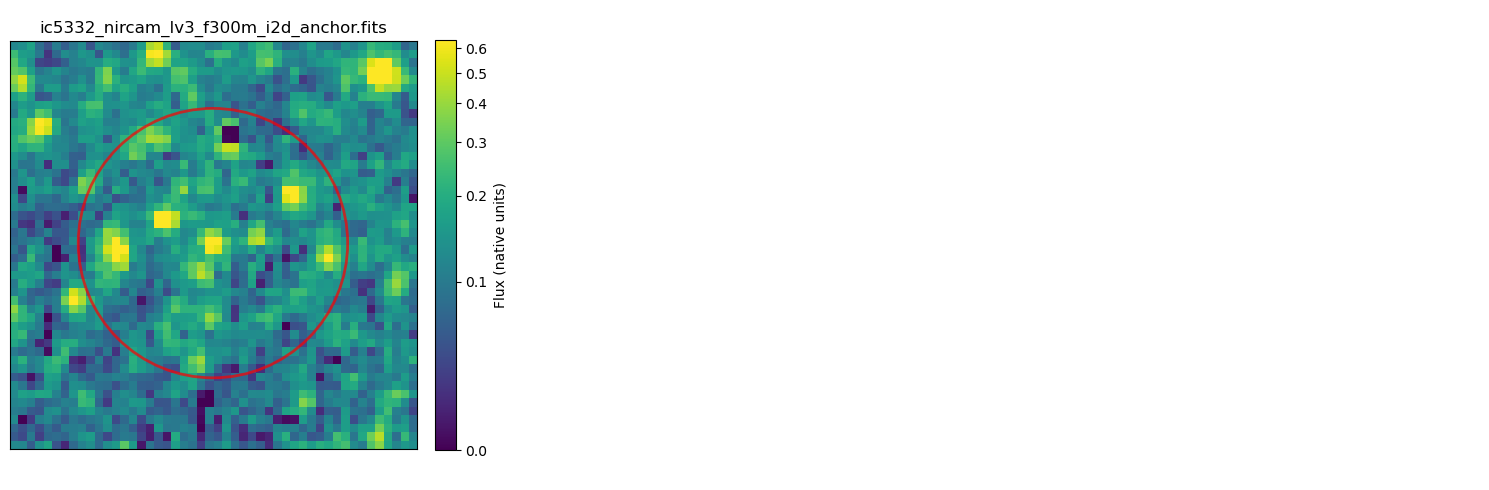

In [68]:
show_images([data['ic5332']['F300M']], loc, 1*u.arcsec)

In [80]:
print(kiana_files[0])
print(kiana_files[1])

Data_files/Kiana_files/ic5332_HST_Ha_all_clusters_results.csv
Data_files/Kiana_files/ic5332_HST_Ha_nircam_all_clusters_results.csv


array(['Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f115w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f140m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f150w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f164n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f182m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f187n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f200w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f210m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f212n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f250m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f300m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f335m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f360m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f405n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nirc

In [87]:
t = Table.read(kiana_files[1], format="csv")
t['best.sfh.age']

53.0
76.0
4.0
4.0
7.0
8.0
6.0
6.0
4.0
110.0
110.0


In [108]:
danny_files = glob.glob('/d/crow2/phangs/cycle*/**/*', recursive=True)
danny_files

['/d/crow2/phangs/cycle2/pa-alpha',
 '/d/crow2/phangs/cycle2/v0p1p14',
 '/d/crow2/phangs/cycle2/v0p1p15',
 '/d/crow2/phangs/cycle2/v0p1p16',
 '/d/crow2/phangs/cycle2/v0p2p0',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p2p0',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ic5273_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ic5273_Pa_line.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1068_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1068_Pa_line.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1097_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1097_Pa_line.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1511_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1511_Pa_line.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1546_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1546_Pa_line.fits',
 '/d/crow2/phangs/cycle2/pa-alpha/v0p1p14/ngc1559_Pa_cont.fits',
 '/d/crow2/phangs/cycle2/

In [123]:



data

{'ic5332': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ic5332_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc628c': {},
 'ngc628e': {},
 'ngc1087': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1087_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc1300': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1300_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc1365': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1365_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc1385': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1385_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc1433': {'F187N_continuum': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_cont.fits',
  'F187N_line': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_line.fits',
  'F150W': '/d/crow2/phangs/cycle3/ngc1433_nircam_lv3_f150w_i2d_anchor.fits',
  'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1433_nircam_lv3_f300m_i2d_anchor.fits'},
 'ngc1512': {'F187N_continuum': '/d/crow2/phangs/cycle3/ngc1512_paa_native_anchor_cont.fits',
  'F187N_line': '/d/crow2/phangs/cycle3/ngc1512_paa_native_anchor_l

In [8]:
data

{'ic5332': {'files': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ic5332_nircam_lv3_f300m_i2d_anchor.fits'}},
 'ngc628c': {'files': {}},
 'ngc628e': {'files': {}},
 'ngc1087': {'files': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1087_nircam_lv3_f300m_i2d_anchor.fits'}},
 'ngc1300': {'files': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1300_nircam_lv3_f300m_i2d_anchor.fits'}},
 'ngc1365': {'files': {'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1365_nircam_lv3_f300m_i2d_anchor.fits'}},
 'ngc1433': {'files': {'F187N_continuum': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_cont.fits',
   'F187N_line': '/d/crow2/phangs/cycle3/ngc1433_paa_native_anchor_line.fits',
   'F150W': '/d/crow2/phangs/cycle3/ngc1433_nircam_lv3_f150w_i2d_anchor.fits',
   'F187N': '/d/crow2/phangs/cycle3/ngc1433_nircam_lv3_f187n_i2d_anchor.fits',
   'F300M': '/d/crow2/phangs/cycle1/v1p1/ngc1433_nircam_lv3_f300m_i2d_anchor.fits'}},
 'ngc1512': {'files': {'F187N_continuum': '/d/crow2/phangs/cycle3/ngc1512_paa_native_anchor_cont.

In [120]:
file = glob.glob('/d/crow2/phangs/cycle*/**/*')
for f in file:
    if 'ngc628' in f:
        print(f)

In [16]:
kiana_files[:2]

['Data_files/Kiana_files/ic5332_HST_Ha_all_clusters_results.csv',
 'Data_files/Kiana_files/ic5332_HST_Ha_nircam_all_clusters_results.csv']

In [14]:
t = Table.read(kiana_files[0])
t[:5]

col0,bayes.attenuation.A550,bayes.attenuation.A550_err,bayes.attenuation.F275W_UVIS_CHIP2,bayes.attenuation.F275W_UVIS_CHIP2_err,bayes.attenuation.F336W_UVIS_CHIP2,bayes.attenuation.F336W_UVIS_CHIP2_err,bayes.attenuation.F438W_UVIS_CHIP2,bayes.attenuation.F438W_UVIS_CHIP2_err,bayes.attenuation.F555W_UVIS_CHIP2,bayes.attenuation.F555W_UVIS_CHIP2_err,bayes.attenuation.F814W_UVIS_CHIP2,bayes.attenuation.F814W_UVIS_CHIP2_err,bayes.attenuation.HST_ACS_WFC.F658N,bayes.attenuation.HST_ACS_WFC.F658N_err,bayes.dust.alpha,bayes.dust.alpha_err,bayes.dust.gamma,bayes.dust.gamma_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umean,bayes.dust.umean_err,bayes.dust.umin,bayes.dust.umin_err,bayes.nebular.f_dust,bayes.nebular.f_dust_err,bayes.nebular.f_esc,bayes.nebular.f_esc_err,bayes.nebular.lines_width,bayes.nebular.lines_width_err,bayes.nebular.logU,bayes.nebular.logU_err,bayes.nebular.ne,bayes.nebular.ne_err,bayes.nebular.zgas,bayes.nebular.zgas_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,bayes.sfh.tau_burst,bayes.sfh.tau_burst_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.stellar.age_m_star,bayes.stellar.age_m_star_err,bayes.stellar.beta0,bayes.stellar.beta0_err,bayes.stellar.imf,bayes.stellar.imf_err,bayes.stellar.metallicity,bayes.stellar.metallicity_err,bayes.stellar.old_young_separation_age,bayes.stellar.old_young_separation_age_err,bayes.universe.age,bayes.universe.age_err,bayes.universe.luminosity_distance,bayes.universe.luminosity_distance_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.sfh.integrated,bayes.sfh.integrated_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.lum,bayes.stellar.lum_err,bayes.stellar.lum_ly,bayes.stellar.lum_ly_err,bayes.stellar.lum_ly_old,bayes.stellar.lum_ly_old_err,bayes.stellar.lum_ly_young,bayes.stellar.lum_ly_young_err,bayes.stellar.lum_old,bayes.stellar.lum_old_err,bayes.stellar.lum_young,bayes.stellar.lum_young_err,bayes.stellar.m_gas,bayes.stellar.m_gas_err,bayes.stellar.m_gas_old,bayes.stellar.m_gas_old_err,bayes.stellar.m_gas_young,bayes.stellar.m_gas_young_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.m_star_old,bayes.stellar.m_star_old_err,bayes.stellar.m_star_young,bayes.stellar.m_star_young_err,bayes.stellar.n_ly,bayes.stellar.n_ly_err,bayes.stellar.n_ly_old,bayes.stellar.n_ly_old_err,bayes.stellar.n_ly_young,bayes.stellar.n_ly_young_err,bayes.F275W_UVIS_CHIP2,bayes.F275W_UVIS_CHIP2_err,bayes.F336W_UVIS_CHIP2,bayes.F336W_UVIS_CHIP2_err,bayes.F438W_UVIS_CHIP2,bayes.F438W_UVIS_CHIP2_err,bayes.F555W_UVIS_CHIP2,bayes.F555W_UVIS_CHIP2_err,bayes.F814W_UVIS_CHIP2,bayes.F814W_UVIS_CHIP2_err,bayes.HST_ACS_WFC.F658N,bayes.HST_ACS_WFC.F658N_err,bayes.jwst.miri.F1000W,bayes.jwst.miri.F1000W_err,bayes.jwst.miri.F1130W,bayes.jwst.miri.F1130W_err,bayes.jwst.miri.F2100W,bayes.jwst.miri.F2100W_err,bayes.jwst.miri.F770W,bayes.jwst.miri.F770W_err,bayes.jwst.nircam.F200W,bayes.jwst.nircam.F200W_err,bayes.jwst.nircam.F300M,bayes.jwst.nircam.F300M_err,bayes.jwst.nircam.F335M,bayes.jwst.nircam.F335M_err,bayes.jwst.nircam.F360M,bayes.jwst.nircam.F360M_err,best.chi_square,best.reduced_chi_square,best.attenuation.A550,best.attenuation.F275W_UVIS_CHIP2,best.attenuation.F336W_UVIS_CHIP2,best.attenuation.F438W_UVIS_CHIP2,best.attenuation.F555W_UVIS_CHIP2,best.attenuation.F814W_UVIS_CHIP2,best.attenuation.HST_ACS_WFC.F658N,best.dust.alpha,best.dust.gamma,best.dust.qpah,best.dust.umean,best.dust.umin,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.beta0,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.a

In [15]:
t = Table.read(kiana_files[1])
t[:5]

col0,bayes.attenuation.A550,bayes.attenuation.A550_err,bayes.attenuation.F275W_UVIS_CHIP2,bayes.attenuation.F275W_UVIS_CHIP2_err,bayes.attenuation.F336W_UVIS_CHIP2,bayes.attenuation.F336W_UVIS_CHIP2_err,bayes.attenuation.F438W_UVIS_CHIP2,bayes.attenuation.F438W_UVIS_CHIP2_err,bayes.attenuation.F555W_UVIS_CHIP2,bayes.attenuation.F555W_UVIS_CHIP2_err,bayes.attenuation.F814W_UVIS_CHIP2,bayes.attenuation.F814W_UVIS_CHIP2_err,bayes.attenuation.HST_ACS_WFC.F658N,bayes.attenuation.HST_ACS_WFC.F658N_err,bayes.attenuation.jwst.nircam.F200W,bayes.attenuation.jwst.nircam.F200W_err,bayes.attenuation.jwst.nircam.F300M,bayes.attenuation.jwst.nircam.F300M_err,bayes.attenuation.jwst.nircam.F335M,bayes.attenuation.jwst.nircam.F335M_err,bayes.attenuation.jwst.nircam.F360M,bayes.attenuation.jwst.nircam.F360M_err,bayes.dust.alpha,bayes.dust.alpha_err,bayes.dust.gamma,bayes.dust.gamma_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umean,bayes.dust.umean_err,bayes.dust.umin,bayes.dust.umin_err,bayes.nebular.f_dust,bayes.nebular.f_dust_err,bayes.nebular.f_esc,bayes.nebular.f_esc_err,bayes.nebular.lines_width,bayes.nebular.lines_width_err,bayes.nebular.logU,bayes.nebular.logU_err,bayes.nebular.ne,bayes.nebular.ne_err,bayes.nebular.zgas,bayes.nebular.zgas_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,bayes.sfh.tau_burst,bayes.sfh.tau_burst_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.stellar.age_m_star,bayes.stellar.age_m_star_err,bayes.stellar.beta0,bayes.stellar.beta0_err,bayes.stellar.imf,bayes.stellar.imf_err,bayes.stellar.metallicity,bayes.stellar.metallicity_err,bayes.stellar.old_young_separation_age,bayes.stellar.old_young_separation_age_err,bayes.universe.age,bayes.universe.age_err,bayes.universe.luminosity_distance,bayes.universe.luminosity_distance_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.sfh.integrated,bayes.sfh.integrated_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.lum,bayes.stellar.lum_err,bayes.stellar.lum_ly,bayes.stellar.lum_ly_err,bayes.stellar.lum_ly_old,bayes.stellar.lum_ly_old_err,bayes.stellar.lum_ly_young,bayes.stellar.lum_ly_young_err,bayes.stellar.lum_old,bayes.stellar.lum_old_err,bayes.stellar.lum_young,bayes.stellar.lum_young_err,bayes.stellar.m_gas,bayes.stellar.m_gas_err,bayes.stellar.m_gas_old,bayes.stellar.m_gas_old_err,bayes.stellar.m_gas_young,bayes.stellar.m_gas_young_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.m_star_old,bayes.stellar.m_star_old_err,bayes.stellar.m_star_young,bayes.stellar.m_star_young_err,bayes.stellar.n_ly,bayes.stellar.n_ly_err,bayes.stellar.n_ly_old,bayes.stellar.n_ly_old_err,bayes.stellar.n_ly_young,bayes.stellar.n_ly_young_err,bayes.F275W_UVIS_CHIP2,bayes.F275W_UVIS_CHIP2_err,bayes.F336W_UVIS_CHIP2,bayes.F336W_UVIS_CHIP2_err,bayes.F438W_UVIS_CHIP2,bayes.F438W_UVIS_CHIP2_err,bayes.F555W_UVIS_CHIP2,bayes.F555W_UVIS_CHIP2_err,bayes.F814W_UVIS_CHIP2,bayes.F814W_UVIS_CHIP2_err,bayes.HST_ACS_WFC.F658N,bayes.HST_ACS_WFC.F658N_err,bayes.jwst.miri.F1000W,bayes.jwst.miri.F1000W_err,bayes.jwst.miri.F1130W,bayes.jwst.miri.F1130W_err,bayes.jwst.miri.F2100W,bayes.jwst.miri.F2100W_err,bayes.jwst.miri.F770W,bayes.jwst.miri.F770W_err,bayes.jwst.nircam.F200W,bayes.jwst.nircam.F200W_err,bayes.jwst.nircam.F300M,bayes.jwst.nircam.F300M_err,bayes.jwst.nircam.F335M,bayes.jwst.nircam.F335M_err,bayes.jwst.nircam.F360M,bayes.jwst.nircam.F360M_err,best.chi_square,best.reduced_chi_square,best.attenuation.A550,best.attenuation.F275W_UVIS_CHIP2,best.attenuation.F336W_UVIS_CHIP2,best.attenuation.F438W_UVIS_CHIP2,best.attenuation.F555W_UVIS_CHIP2,best.attenuation.F814W_UVIS_CHIP2,best.attenuation.HST_ACS_WFC.F658N,best.attenuation.jwst.nircam.F200W,best.attenuation.jwst.nircam.F300M,best.attenuation.jwst.nircam.F335M,best.atte

In [15]:
file = '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F300M.dat'
data = np.genfromtxt(file)
for line in data:
    print(line[0], line[1])

27011.1 0.000103927
27024.6 0.000107417
27038.1 0.000112416
27051.7 0.000118399
27065.2 0.000124955
27078.7 0.000129533
27092.2 0.000135358
27105.7 0.000140734
27119.2 0.00015072
27132.7 0.00015911
27146.2 0.000164392
27159.8 0.000171301
27173.3 0.000181434
27186.8 0.000192534
27200.3 0.000201899
27213.8 0.000214611
27227.3 0.000227721
27240.8 0.000241396
27254.3 0.000255687
27267.9 0.000268673
27281.4 0.000286485
27294.9 0.000307932
27308.4 0.000330437
27321.9 0.000354781
27335.4 0.000379699
27348.9 0.000407978
27362.4 0.000444412
27375.9 0.000476524
27389.5 0.000516087
27403.0 0.000562366
27416.5 0.000615465
27430.0 0.000671417
27443.5 0.000731596
27457.0 0.000800597
27470.5 0.000878055
27484.0 0.000963636
27497.6 0.00105425
27511.1 0.00115705
27524.6 0.00126693
27538.1 0.00138531
27551.6 0.0015237
27565.1 0.00167028
27578.6 0.00182847
27592.1 0.00200202
27605.7 0.00219329
27619.2 0.00239798
27632.7 0.00261972
27646.2 0.00286029
27659.7 0.00312166
27673.2 0.0033995
27686.7 0.00369805